# Hello Network Analysis!

Date created: March 27, 2024

Author: Jonathan Bui

In [34]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

- get a list of all the proteins seen in a dataset
- filter the STRING network to only contain proteins seen in that dataset
- load the smaller graph in NetworkX
- perform ??? analysis, look up tutorials

In [6]:
pg_matrix = pd.read_csv("data/PXD047236_DIANN_report.pg_matrix.tsv", sep="\t")
pg_matrix.head()

,Protein.Group,Protein.Ids,Protein.Names,Genes,First.Protein.Description,1Y6.mzML,1Y9.mzML,1Y14.mzML,2Y2.mzML,2Y9.mzML,...,2Y8.mzML,1W7.mzML,1W11.mzML,2W6.mzML,1Y2.mzML,2Y14.mzML,2Y7.mzML,1W13.mzML,2W15.mzML,2W3.mzML
0,A0A075B6H7;A0A0C4DH55,P01624;A0A075B6H7;A0A0C4DH55,KV37_HUMAN;KVD07_HUMAN,IGKV3-7;IGKV3D-7,NaN,5360000.0,4440000.0,3280000.0,2090000.0,3990000.00,...,4020000.0,4330000.0,3070000.0,15300000.0,6480000.0,1840000.0,1600000.0,3170000.0,4780000.0,2440000.0
1,A0A075B6I0,A0A075B6I0,LV861_HUMAN,IGLV8-61,NaN,220297.0,84993.6,188674.0,48123.3,78052.70,...,50566.2,62810.8,608445.0,69480.7,NaN,201605.0,32804.6,NaN,290068.0,381436.0
2,A0A075B6I9,A0A075B6I9,LV746_HUMAN,IGLV7-46,NaN,14661.2,NaN,10053.2,NaN,3168.52,...,29221.7,15855.0,NaN,19316.9,NaN,NaN,NaN,13356.0,NaN,24585.1
3,A0A075B6I9;P04211,P04211;A0A075B6I9,LV743_HUMAN;LV746_HUMAN,IGLV7-43;IGLV7-46,NaN,70729.0,337457.0,93126.2,820218.0,74922.70,...,693517.0,606087.0,116589.0,1500000.0,198801.0,265399.0,48102.3,913847.0,261519.0,950739.0
4,A0A075B6J9,A0A075B6J9,LV218_HUMAN,IGLV2-18,NaN,NaN,NaN,17325.4,NaN,NaN,...,12767.3,20333.4,NaN,NaN,NaN,NaN,NaN,12879.2,NaN,NaN


In [10]:
full_network = pd.read_csv("data/string/9606.protein.physical.links.v12.0.txt", sep=" ")
full_network.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000257770,311
1,9606.ENSP00000000233,9606.ENSP00000226004,161
2,9606.ENSP00000000233,9606.ENSP00000434442,499
3,9606.ENSP00000000233,9606.ENSP00000262455,531
4,9606.ENSP00000000233,9606.ENSP00000303145,499


The DIA-NN data uses UniProt protein accessions because the spectral library was derived from protein sequences in the UniProt database, and STRING uses its own protein IDs.

The [UniProt ID mapping tool](https://www.uniprot.org/id-mapping) is useful for this scenario and can generate a 1-to-1 mapping of protein IDs between each database. In this case, the id-mapping job was submitted manually through a web interface, but this task can also be achieved programmatically on the command-line (see [UniProt documentation](https://www.uniprot.org/help/id_mapping)).

In [4]:
id_mapping_result = pd.read_csv("data/idmapping_2024_03_27.tsv", sep="\t")
id_mapping_result.head()

,From,To
0,A0A075B6S2,9606.ENSP00000483567
1,A0A0B4J1V0,9606.ENSP00000479675
2,A0A0B4J1Y9,9606.ENSP00000480035
3,A0A0C4DH29,9606.ENSP00000479119
4,A0A1W2PQ73,9606.ENSP00000491574
...,...,...
1407,Q9Y6C2,9606.ENSP00000369677
1408,Q9Y6N7,9606.ENSP00000420321
1409,Q9Y6R7,9606.ENSP00000481056
1410,Q9Y6U3,9606.ENSP00000297029


In [15]:
# filter the network edges to contain only proteins that exist in the dataset
# could also choose to include proteins one degree away from the observed network of proteins, but I want to start with the smallest network
observed_network = full_network[full_network["protein1"].isin(id_mapping_result.To)]
observed_network = observed_network[observed_network["protein2"].isin(id_mapping_result.To)]
observed_network

,protein1,protein2,combined_score
475,9606.ENSP00000002165,9606.ENSP00000324173,191
482,9606.ENSP00000002165,9606.ENSP00000322323,499
492,9606.ENSP00000002165,9606.ENSP00000285599,240
494,9606.ENSP00000002165,9606.ENSP00000363603,916
495,9606.ENSP00000002165,9606.ENSP00000247461,330
...,...,...,...
1476677,9606.ENSP00000500990,9606.ENSP00000315130,603
1476679,9606.ENSP00000500990,9606.ENSP00000302961,929
1476695,9606.ENSP00000500990,9606.ENSP00000299767,373
1476707,9606.ENSP00000500990,9606.ENSP00000256637,165


In [31]:
# get nodes
nodes = pd.Series(observed_network["protein1"].values, observed_network["protein2"].values).unique()
nodes[:5]

array(['9606.ENSP00000002165', '9606.ENSP00000002829',
       '9606.ENSP00000005286', '9606.ENSP00000005587',
       '9606.ENSP00000007735'], dtype=object)

In [32]:
# TODO: preserve weights (combined_score confidence)
edges = list(zip(observed_network["protein1"].values, observed_network["protein2"].values))
edges[:5]

[('9606.ENSP00000002165', '9606.ENSP00000324173'),
 ('9606.ENSP00000002165', '9606.ENSP00000322323'),
 ('9606.ENSP00000002165', '9606.ENSP00000285599'),
 ('9606.ENSP00000002165', '9606.ENSP00000363603'),
 ('9606.ENSP00000002165', '9606.ENSP00000247461')]

In [33]:
# loop thrugh the dataframe to construct the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

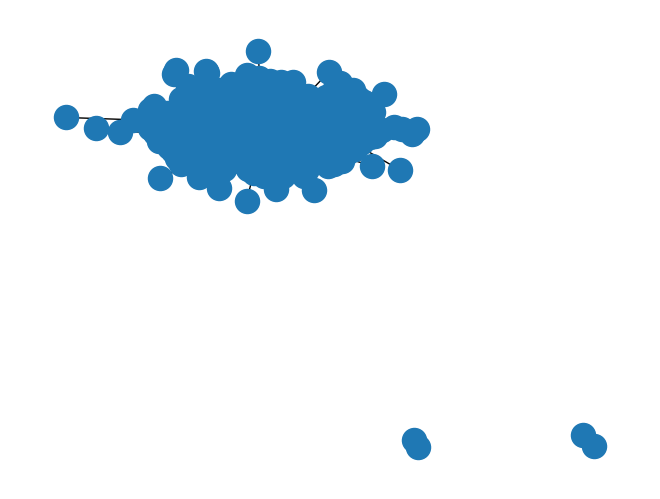

In [37]:
nx.draw(G, with_labels=False, font_weight='bold')